# Рекомендация тарифов клиентам мобильного оператора

Оператор мобильной связи **«Мегалайн»** выяснил: многие клиенты пользуются *архивными тарифами*. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: **«Смарт»** или **«Ультра»**.

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 

**Нужно построить модель для задачи классификации**, которая выберет **подходящий тариф**. 

Предобработка данных не понадобится — мы её уже сделали (в проекте курса *«Статистический анализ данных»*).

**Цель:** построить модель с **максимально большим значением `accuracy`**, нужно довести долю правильных ответов по крайней мере до 0.75. Проверять *accuracy* будем на тестовой выборке.

## Изучение данных из файла

Для начала **импортируем библиотеки**, которые будем использовать в ходе исследования:
- `pandas`,
- `numpy`,
- модуль `pyplot` библиотеки `matplotlib`,
- `DecisionTreeClassifier` из модуля `sklearn.tree` (структура данных для классификации деревом решений),
- `accuracy_score` из модуля `sklearn.metrics` (для вычисления доли правильных ответов),
- `train_test_split` из модуля `sklearn.model_selection` (для разделения исходной выборки на обучающую, тестовую и валидационную),
- `RandomForestClassifier` (классификатор случайного леса) из модуля `sklearn.ensemble`,
- `LogisticRegression` из модуля `sklearn.linear_model` (логистическая регрессия),
- `DummyClassifier` из модуля `sklearn.dummy`,
- `confusion_matrix`из модуля `sklearn.metrics`,
- `classification_report` из модуля `sklearn.metrics`.

In [1]:
# импорт библиотеки pandas
import pandas as pd

# импорт библиотеки pnumpy
import numpy as np

# импорт pyplot из библиотеки matplotlib
import matplotlib.pyplot as plt

# импорт express из библиотеки plotly
import seaborn as sns

# импорт модели дерева решений из модуля sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# импорт accuracy_score из модуля sklearn.metrics
from sklearn.metrics import accuracy_score

# импортируем train_test_split из модуля sklearn.model_selection
from sklearn.model_selection import train_test_split 

# импортируем RandomForestClassifier из модуля sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

# импортируем LogisticRegression  из модуля sklearn.linear_model
from sklearn.linear_model import LogisticRegression 

#для проверки модели на адекватность
from sklearn.dummy import DummyClassifier

#для построения матрицы ошибок
from sklearn.metrics import confusion_matrix

#позволяет получить более развернутый отчет о точности, полноте и f1-мере
from sklearn.metrics import classification_report

**Прочитаем файл** `users_behavior.csv` из папки `/datasets`.
Cохраним содержимое в переменной `df`:

In [2]:
# чтение файла с данными и сохранение в df
df = pd.read_csv('/datasets/users_behavior.csv')

Выведем общую информацию о таблице с использованием метода `info()`:

In [3]:
# вывод общей информации о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Выведем первые 10 строк таблицы:

In [4]:
# вывод первых строк таблицы
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Итак, в исходной таблице **3214** объектов (строк таблицы). 

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Для каждого объекта есть информация о **5 признаках**, из которых целевым является `is_ultra`, означающий какой тариф у клиента: если `1` - тариф "Ультра", если `0` - тариф "Смарт".


Из описания данных также известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом клиент пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


Проверим есть ли мультиколлинеарность признаков. 

Построим матрицу корреляции признаков и матрицу диаграмм рассеяния:

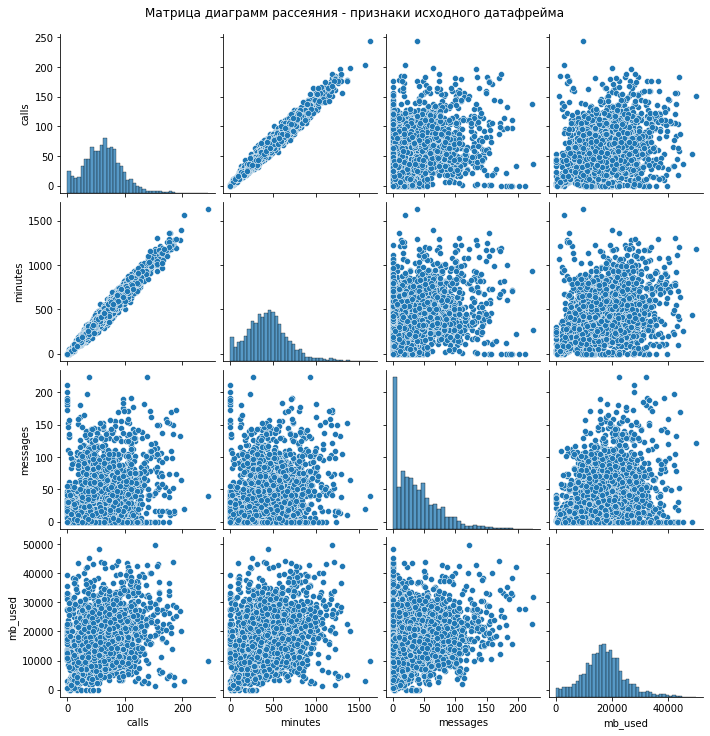

In [5]:
(
    sns.pairplot(df[["calls", "minutes", "messages", "mb_used"]])
    .fig.suptitle("Матрица диаграмм рассеяния - признаки исходного датафрейма",y=1.02)
)

plt.show()

Совершенно чётко видна зависимость между количеством звонков и минут. Можно было бы оставить для дальнейшего исследования только минуты, чтобы, кстати, не учитывать в количестве всех звонков ещё и пропущенные вызовы, которые приведут к искажению результатов. Количество израсходованных минут - более информативный признак, чем количество звонков. Но, учитывая, что проект учебный, рассмотрим все признаки.

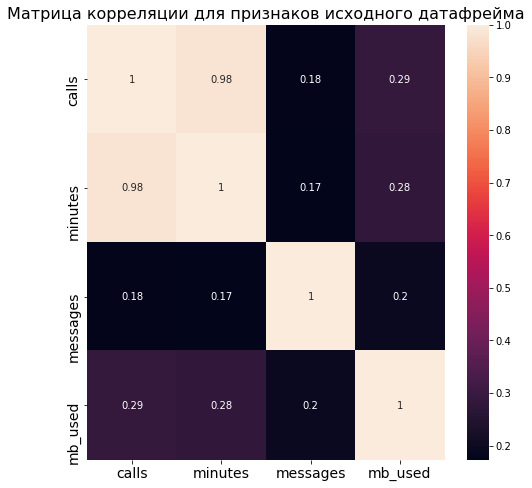

In [6]:
# импорт библиотеки seaborn
import seaborn as sns

plt.figure(figsize=(8,8))

sns.heatmap(
    df[["calls", "minutes", "messages", "mb_used"]]
    .corr(),
    annot=True)

#название графика
plt.title('Матрица корреляции для признаков исходного датафрейма', fontsize=16 )

#задаём размер значений на оси абсцисс и на оси ординат
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Теперь видим количественное подтверждение результата, полученного на диаграмме рассеяния: между количеством израсходованных минут и количеством звонков сильная положительная зависимость, коэффициент корреляции Пирсона близок к единице.

### Вывод

В исходной таблице **3214** объектов. 

Каждый объект — информация о поведении одного пользователя за месяц.

Доступна информация о 5 признаках: количество звонков, суммарная дилтельность звонков в минутах, количетсво sms, израсходованный интернет трафик в Мб, каким тарифом пользовался клиент в течение месяца.

Целевой признак - столбец `is_ultra` (какой тариф).

Предварительно можно утвержать, что **данных для исследования достаточно**.

Так как предобработка данных выполнена ранее, то переходим к разбивке на выборки.

## Разбивка данных на выборки

Разобъём исходную выборку на обучающущю, валидационную и тестовую в соотношении (3:1:1): 

|Выборка |Процент от количества объектов исходной выборки|
|:-----|:----:|
|Обучающая|60%|
|Валидационная|20%|
|Тестовая|20%|



Теперь отложим тестовую выборку (20%), в обучающей оставим 80% исходного датасета (чтобы в дальнейшем выделить валидационную).

Используем `train_test_split` из модуля `sklearn.model_selection`. Разбивку произведём псевдослучайным образом, задав параметр `random_state` равным `12345`.


In [7]:
# первый шаг разбивки - откладываем тестовую выборку, 
# в обучающей оставляем 80%, чтобы затем из неё
# выделить валидационную
df_train, df_test = train_test_split(df, 
                                     test_size=0.20, 
                                     random_state=12345) 

Теперь нужно из обучающей выборки выделить валидационную. 20% от 80% это 1/4, или 25% от 100%:

In [8]:
# Второй шаг разбивки - выделяем из 80% оставшихся процентов обучающую и валидационную выборки.
# В обучающей оставляем 60% из 80%, в валидационной 20% из 80%, то есть 1/4, или 25% из 100%
df_train, df_valid = train_test_split(df_train, 
                                      test_size=0.25, 
                                      random_state=12345) 

Проверим результат разбивки: количество строк в трех получившихся датафреймах в сумме должно быть равно исходному количеству объектов.

Для визуального ознакомления выведем количество объектов и признаков в каждой из выборок:

In [9]:
#количество объектов и признаков в тестовой выборке
df_test.shape

(643, 5)

In [10]:
#количество объектов и признаков в обучающей выборке
df_train.shape

(1928, 5)

In [11]:
#количество объектов и признаков в валидационной выборке
df_valid.shape

(643, 5)

Просуммируем количество объектов в каждой из выборок:

In [12]:
# суммарное количество объектов в трех выборках
df_test.shape[0]+df_train.shape[0]+df_valid.shape[0]

3214

Сопоставим с количеством объектов в исходной выборке:

In [13]:
#количество объектов в исходной выборке
df.shape[0]

3214

Очевидно, что разбивка на выборки выполнена успешно: котрольная сумма сходится.

### Вывод

Разбивка на обучающую, тестовую и валидационную выборки выполнена в соотношении **3:1:1**. Проверка контрольной суммы количества объектов показала, что разбивка выполнена корректно. Можно переходить к исследованию моделей.

## Исследование моделей

Для решения поставленной задачи классификации далее рассмотрим **3 модели** машинного обучения:
- дерево решений, 
- случайный лес, 
- логистическую регрессию.

Выполним первый шаг - разделим исходный набор данных на *тестовый, обучающий и валидационный*, используя выборки, полученные на предыдущем шаге.

### Тестовый, обучающий и валидационный наборы данных

Сохраним обучающий, тестовый и валидационный наборы данных в переменных `features` (признаки) и `target` (целевой признак).

Для этого создадим переменные для **признаков и целевого признака**. 

Сделаем это с использованием цикла по выборкам.

Массив с названиями выборок:

In [14]:
#создаём массив с названиями выборок
array = ['test','train','valid']

**Целевой признак - столбец `is_ultra`**. Соответственно его нужно удалить для признаков в наборах данных всех выборок . 

Цикл для выделения признаков, и целевого признака в каждой из выборок:

In [15]:
#цикл по названию выборки
for name in array:
    
    #признаки для текущей выборки
    locals()['features_'+name] = (locals()['df_'+name]
                                  .drop(['is_ultra'], 
                                        axis=1))
    
    #вывод на экран именени переменной для таблицы признаков текущей выборки и её размерности
    print('features_'+name, 'shape:', 
          locals()['features_'+name].shape)
    
    #целевой признак для текущей выборки
    locals()['target_'+name] = (locals()['df_'+name]
                                ['is_ultra'])
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('target_'+name, 'shape:',
          locals()['target_'+name].shape)
    
    print()

features_test shape: (643, 4)
target_test shape: (643,)

features_train shape: (1928, 4)
target_train shape: (1928,)

features_valid shape: (643, 4)
target_valid shape: (643,)



С помощью цикла мы сохранили **признаки и целевой признак** наборов данных в переменных:
- `features_test`, `target_test` - для тестовой выборки ,
- `features_train`, `target_train` - для обучающей выборки,
- `features_valid`, `target_valid`- для валидационной выборки.

Проверка размерности подтверждает правильность выделения признаков и целевого признака.

### Сбалансированность выборки целевого признака

Перед исследованием различных моделей посмотрим насколько сбалансирована выборка целевого признака в исходном датафрейме. Для этого посчитаем среднее в столбце `is_ultra`:

In [16]:
#вычисление среднего значения в столбце 'is_ultra'
df['is_ultra'].mean()

0.30647168637212197

Только около **`30.6%`** пользователей в исходной таблице имеют тариф **"Ультра"**. То есть в данном случае мы имеем дело с **несбалансированным целевым признаком**, который наиболее часто встречается в реальной жизни. Нет равного разделения 50/50 между пользователями тарифов Смарт и Ультра.

Посмотрим насколько сбалансирован целевой признак в тестовой, обучающей и валидационной выборках. Для этого снова воспользуемся циклом:

In [17]:
print('Доля пользователей с тарифом Ультра для:')

#цикл по названию выборки
for name in array:
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('-', name, 'выборки: ',
          locals()['target_'+name].mean())

Доля пользователей с тарифом Ультра для:
- test выборки:  0.3048211508553655
- train выборки:  0.30549792531120334
- valid выборки:  0.3110419906687403


Из полученного результата очевидно, что разбивка на тестовую, обучающую и валидационную выборки выполнена с сохранением несбалансированного целевого признака: клиентов с тарифом **Смарт около 70%**.

При дальнейшем исследовании моделей необходимо иметь в виду, что заполнение целевого признака наиболее встречающимся значением (в данном случае это `0` - не тариф "Ультра", то есть "Смарт") приведет к **правильности** такой случайной модели равной не менее 70%. То есть предварительно будем считать, что модель можно считать адекватной, если её *правильность* **превышает 70%**. 

После исследования моделей попробуем вернуться к проверке их адекватности.

### Модель  решающего дерева

Начнем исследование моделей с решающего дерева.

В модели решающего дерева будем работать с **2 гиперпараметрами**:
- псевдослучайностью `random_state` зададим равной `12345`,
- максимальной глубиной решающего дерева `max_depth`.

Для исследования модели решающего дерева создадим следующие счетчики, которые будем использовать в дальнейшем в цикле:

In [18]:
best_model_tree = None #переменная для сохранения лучшей модели на валидационной выборке
best_result_tree = 0   #переменная для лучшего результата модели на валидационной выборке
best_depth_tree = 0    #переменная для глубины реш. дерева лучшей модели на валидационной выборке
result_tree_score = [] #запишем сюда правильность для каждого варианта глубины решающего дерева
result_tree_depth = [] #здесь сохраним глубину решающего дерева для каждого шага цикла

Теперь с помощью цикла определим модель с лучшей правильностью, выведем на экран найденное значение правильности для неё и соответствующую глубину решающего дерева. 

Глубину решающего дерева в цикле **ограничим** значением **30**. 

Внутри цикла будем:
- **создавать модель** с текущим значением глубины, 
- затем **обучать модель** на обучающей выборке, 
- рассчитывать **правильность** на валидационной,
- и проверять с помощью условия является ли полученное **значение максимальным**,
- если мы обнаружим максимальное значение, то будем сохранять модель, её результат расчета правильности на валидаицонной выборке и глубину решающего дерева.

Также внутри цикла будем сохранять в массивы глубину дерева и рассчитанную правильность модели для каждого шага цикла. Это понадобится для визуализации результата.

Запишем цикл:

In [19]:
#цикл по глубине решающего дерева
for depth in range(1,31):
    
    #создаём объект структуры данных дерева решений
    model_tree = DecisionTreeClassifier(random_state=12345, #добавляем псевдослучайность в алгоритм обучения
                                        max_depth=depth)    #на каждом шаге цикла меняем глубину решающего дерева
    
    #запускаем обучение модели на обучающей выборке
    model_tree.fit(features_train,target_train)
    
    #применяем модель для предсказания ответов на валидационной выборке
    predictions_valid = model_tree.predict(features_valid)
    
    # посчитаем качество модели
    result = model_tree.score(features_valid,target_valid)
    
    # сохраняем текующую глубину решающего дерева для каждого шага цикла
    result_tree_depth.append(depth)
    
    # сохраняем оценку правильности модели для каждого шага цикла
    result_tree_score.append(result)
    
    #ищем модель с лучшим результатом
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth

#выводим на экран accuracy лучшей модели
print("Accuracy лучшей модели:", best_result_tree)
print("Глубина решающего дерева лучшей модели:", best_depth_tree)

Accuracy лучшей модели: 0.7744945567651633
Глубина решающего дерева лучшей модели: 7


Получили правильность модели около **77,499%** с глубиной решающего дерева равной **7**. 

Сохраним результаты исследования качества модели решающего дерева в датафрейм:

In [20]:
#сохраняем результаты исследования качества модели решающего дерева
result_tree = pd.DataFrame({'depth':np.array(result_tree_depth),
                            'tree_score':np.array(result_tree_score)})

**Визуализируем зависимость правильности модели решающего дерева на валидационной выборке от глубины**:

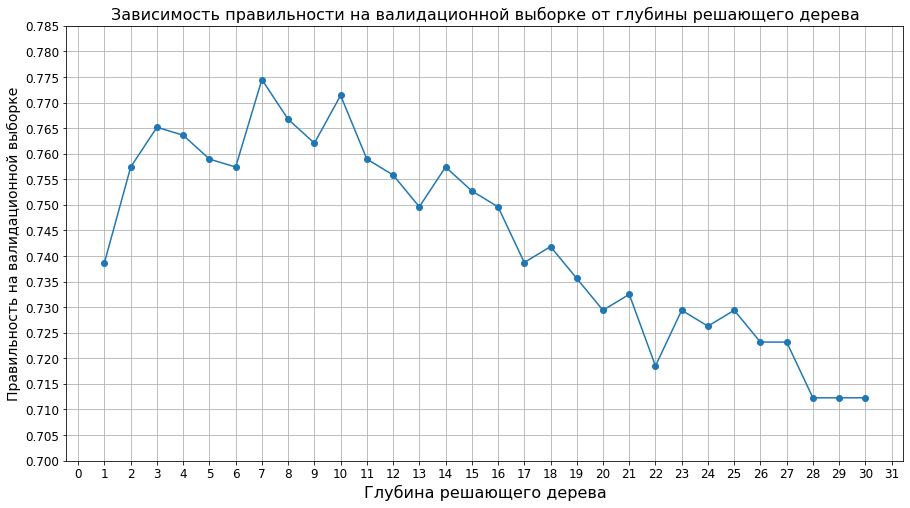

In [21]:
#размер графика
plt.figure(figsize=(15,8))

#строим график
plt.plot(result_tree['depth'],
         result_tree['tree_score'],
        'o-')

#название графика
plt.title('Зависимость правильности на валидационной выборке от глубины решающего дерева', fontsize=16)

#подписи осей
plt.xlabel('Глубина решающего дерева', fontsize=16)
plt.ylabel('Правильность на валидационной выборке', fontsize=14)

#отображение сетки
plt.grid()


#задаём шаг сетки по оси по оси абсцисс и по оси ординат
plt.xticks(np.arange(0, 
                     (result_tree['depth'].max()*1.05), 
                     step=1),
           fontsize=12)
plt.yticks(np.arange(0.7, 
                     (result_tree['tree_score'].max()*1.02), 
                     step=0.005), 
           fontsize=12)

plt.show()

Из полученного графика можно сделать вывод, что правильность модели решающего дерева на валидационной выборке по мере увеличения глубины дерева **растет до достижения значения глубины, равного 7**. 

**При глубине 7 наблюдается максимум правильности.**

Затем с увеличением глубины начинается постепенное снижение правильности. Дальнейшее увеличение глубины приводит только к **ухудшению** правильности модели решающего дерева.

Переходим к модели случайного леса.

### Модель случайного леса

Перейдём к модели случайного леса. 
Будем использовать **3 гиперпараметра**:
- псевдослучайность `random_state` (зададим равным `12345`),
- количество деревьев в лесу `n_estimators`,
- максимальная глубина решающего дерева `max_depth`.

Исследование проведём для двух случаев: 
- не учитываем максимальную глубину решающего дерева, 
- с учетом влияния максимальной глубины решающего дерева.

#### Варьирование количества деревьев (без учета максимальной глубины решающего дерева)

Для начала проведём исследование *без учета максимальной глубины решающего дерева*. Для этого создадим функцию `random_forest_research`, которая позволит с помощью цикла выполнить поиск модели с лучшим результатом правильности на валидаицонной выборке.

Внутри цикла функции будут выполняться следующие шаги:
- модель с заданным количетством деревьев будет обучаться на обучающей выборке,
- затем будет выполняться расчет правильности на валидационной выборке,
- в блоке `if` будет выполняться проверка результата расчета правильности на превышение максимального значения (будем искать модель с максимальной **правильностью**).

В функцию будем передавать:
- минимальное количество деревьев,
- максимальное количество деревьев,
- шаг по количеству деревьев для цикла.

Функция будет возвращать:
- `result_n_estimators`, `result_forest_score` - массивы с количеством деревьев и правильностью для каждого шага цикла, 
- `best_model_forest` - сохранённую лушую модель случайного леса без учета максимальной глубины (для валидационной выборки), 
- `best_result_forest` - результат расчета её правильности (на валидационной выборке),
- `best_result_est` - количество деревьев в ней.

Запишем функцию `random_forest_research`:

In [22]:
def random_forest_research(min_n_estimators,
                           max_n_estimators,
                           step_n_estimators):
    
    #блок счетчиков для цикла
    best_model_forest = None #здесь будет сохранена лучшая модель
    best_result_forest = 0   #здесь сохраним правильность лучшей модели на валидационной выборке
    best_result_est = 0      #переменная для сохранения количества деревьев в лучшей модели
    result_forest_score = [] #запишем сюда правильность для каждого варианта количества деревьев
    result_n_estimators = [] #сохраним количество деревьев для каждого варианта 
    
    #цикл по количеству деревьев
    for est in range(min_n_estimators, 
                     max_n_estimators+1,
                     step_n_estimators):
        
        # модель случайного леса с заданным количеством деревьев
        model_forest = RandomForestClassifier(random_state=12345, 
                                              n_estimators=est)
        
        # обучим модель на тренировочной выборке
        model_forest.fit(features_train,target_train) 
        
        # посчитаем качество модели на валидационной выборке
        result = model_forest.score(features_valid,target_valid)
        
        #массивы с количеством деревьев и правильностью для каждого шага цикла
        result_n_estimators.append(est)
        result_forest_score.append(result)
        
        if result > best_result_forest:
            best_model_forest = model_forest  #сохраним наилучшую модель
            best_result_forest = result       #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_result_est = est             #сохраним количество деревьев лучшей модели
    
    print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_result_forest)
    print("Количество деревьев наилучшей модели случайного леса на валидационной выборке:", best_result_est)
    
    return (result_n_estimators,
            result_forest_score,
            best_model_forest, 
            best_result_forest, 
            best_result_est)

Теперь вызовем функцию для **2000** деревьев в лесу с шагом **50**:

In [23]:
#применяем функцию для 2000 деревьев в лесу с шагом 50
(
    result_n_estimators,
    result_forest_score,
    best_model_forest, 
    best_result_forest, 
    best_result_est) = random_forest_research(1,2000,50)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.7993779160186625
Количество деревьев наилучшей модели случайного леса на валидационной выборке: 151


Сохраним результаты оценки качества для каждого варианта количества деревьев в датафрейм `result_forest`:

In [24]:
#датафрейм для исследования результатов
result_forest = pd.DataFrame({'n_estimators':np.array(result_n_estimators),
                             'forest_score':np.array(result_forest_score)})

Сделаем функцию построения графика для исследования зависимости правильности от количества деревьев в случайном лесу. В неё будут передаваться 2 столбца `result_forest` (`n_estimators` и `forest_score`) и шаг по оси абсцисс:

In [25]:
def plt_result_forest(n_estimators,forest_score,step_x, line_type):
    #размер графика
    plt.figure(figsize=(15,8))
    
    #строим график
    plt.plot(n_estimators,
             forest_score,
             line_type)
    
    #название графика
    plt.title('Зависимость правильности на валидационной выборке от количества деревьев в модели случайного леса', fontsize=16)
    
    #подписи осей
    plt.xlabel('Количество деревьев', fontsize=16)
    plt.ylabel('Правильность на валидационной выборке', fontsize=14)
    
    #отображение сетки
    plt.grid()
    
    
    #задаём шаг сетки по оси по оси абсцисс и по оси ординат
    plt.xticks(np.arange(0, 
                         (n_estimators.max()*1.05), 
                         step=step_x),
               fontsize=12)
    plt.yticks(np.arange(0.7, 
                         (forest_score.max()*1.02), 
                         step=0.005), 
               fontsize=12)
    
    plt.show()

Построим график зависимости правильности на валидационной выборке от количества деревьев в модели случайного леса:

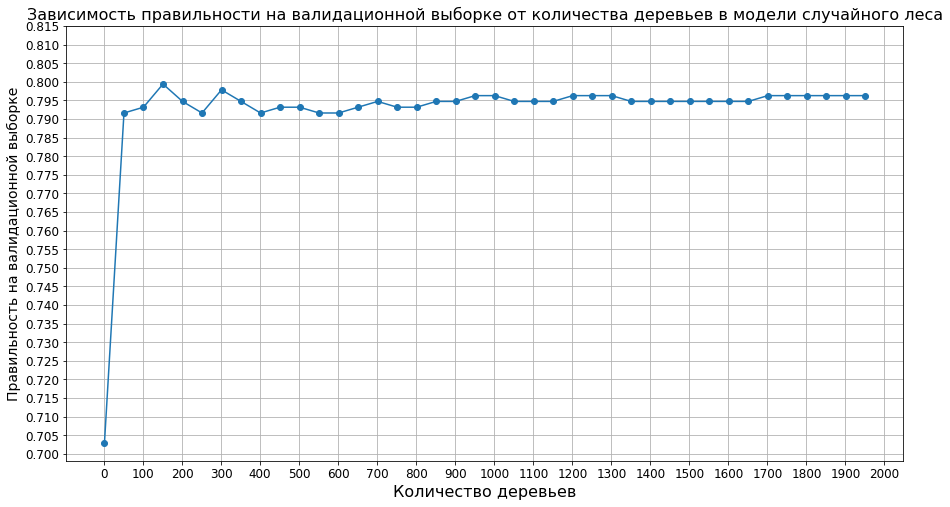

In [26]:
#строим график с использованием функции для результатов исследования качества
plt_result_forest(result_forest['n_estimators'],
                  result_forest['forest_score'],
                  100,'o-')

Из графика видно, что максимум правильности был зафиксирован с количеством деревьев **до 300 штук**. Поэтому с использованием ранее подготовленных функций повторим исследование, но для максимального количества деревьев **300 штук** и с более мелким шагом - `1`.

In [27]:
#применяем функцию для меньшего количества деревьев с более мелким шагом цикла
(
    result_n_estimators_2,
    result_forest_score_2,
    best_model_forest_2, 
    best_result_forest_2, 
    best_result_est_2) = random_forest_research(1,300,1)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.8009331259720062
Количество деревьев наилучшей модели случайного леса на валидационной выборке: 146


Правильность немного улучшилась, как видно из результата.

Обновим исследовательский датафрейм:

In [28]:
#обновляем датафрейм для исследования результатов
result_forest_2 = pd.DataFrame({'n_estimators':np.array(result_n_estimators_2),
                                'forest_score':np.array(result_forest_score_2)})

Построим график:

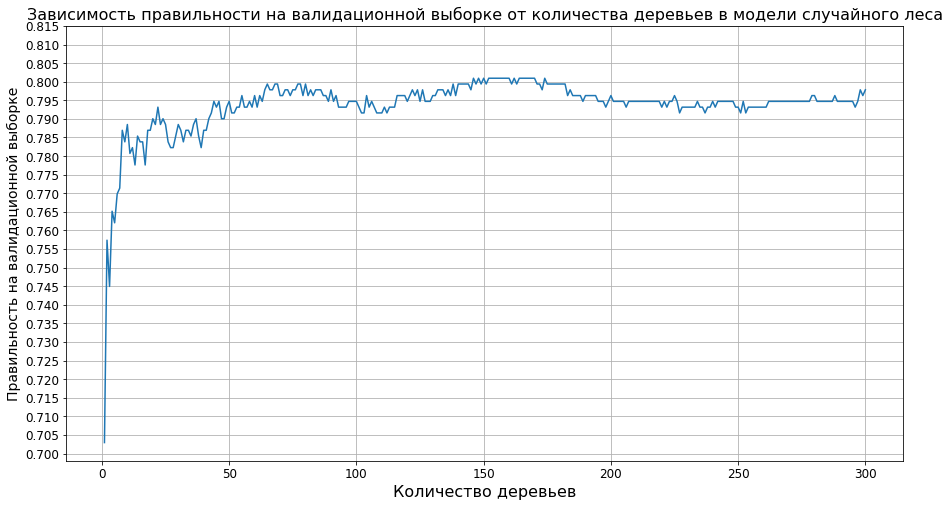

In [29]:
#строим график с использованием функции для результатов исследования качества
plt_result_forest(result_forest_2['n_estimators'],
                  result_forest_2['forest_score'],
                  50, '-')

Ограничение максимального количества деревьев значением **300** и цикл с более мелким шагом по количеству деревьев позволили получить модель случайного леса с правильностью равной **0.800933** с количеством деревьев **146**.

#### Варьирование количества деревьев и максимальной глубины решающего дерева

Продолжим исследование. Посмотрим как повлияет на результат другой **гиперпараметр - глубина решающего дерева** для модели случайного леса.

Для начала зададим максимальную глубину решающего дерева, ограничим её **значением 20**:

In [30]:
#максимальное значение глубины решающего дерева
max_forest_depth = 20

Введём счетчики для цикла:

In [31]:
best_model_forest_depth = None #переменная для сохранения лучшей модели на валидационной выборке
best_result_forest_depth = 0   #переменная для лучшего результата правильности модели на валидационной выборке
best_result_est_for_depth = 0  #переменная для глубины реш. дерева лучшей модели на валидационной выборке
best_result_depth_forest = 0   #максимальная глубина решающего дерева в лучшей моделе

result_forest_depth_score = [] #запишем сюда правильность для каждого варианта количества деревьев
result_n_estimators_depth = [] #сохраним количество деревьев для каждого варианта 
result_depth_forest = []       #сохраним в данной переменной максимальную глубину решающего дерева для каждого шага цикла

Используем вложенный цикл для поиска наилучшей модели случайного леса. 

Внутри цикла на этот раз будем менять не только количество деревьев, но и максимальную глубину решающего дерева.

Последовательность шагов внутри вложенного цикла аналогична выполняемой в предыдущем разделе, отличие только в наличии ещё одного гиперпараметра модели `max_depth`. 
Поэтому внутри цикла:
- модель с заданным количетством деревьев и глубиной решающего дерева будет обучаться на обучающей выборке,
- затем будет выполняться расчет правильности на валидационной выборке,
- в блоке `if` будет выполняться проверка результата расчета правильности на превышение максимального значения (будем искать модель с максимальной **правильностью**).

В результате расчитаем:
- `result_n_estimators_depth`, `result_forest_depth_score` , **`result_depth_forest`**- массивы с количеством деревьев, правильностью и **глубиной решающего дерева** для каждого шага цикла, 
- `best_result_forest_depth` - сохранённую лушую модель случайного леса **с учетом максимальной глубины (для валидационной выборки)**, 
- `best_result_est_for_depth` - результат расчета её правильности (на валидационной выборке),
- `best_result_depth_forest` - количество деревьев в ней.

Запустим цикл в диапазоне **количества деревьев от 1 до 160 с шагом 10**, вложенный цикл по максимальной глубине `max_forest_depth`:

In [32]:
for est in range(11, 161,10):
    for depth in range(1,(max_forest_depth+1)):
        # модель случайного леса с заданным количеством деревьев
        model_forest_depth = RandomForestClassifier(random_state=12345, 
                                                    n_estimators=est,
                                                    max_depth=depth)
    
        # обучим модель на тренировочной выборке
        model_forest_depth.fit(features_train,target_train) 
        
        # посчитаем качество модели на валидационной выборке+
        result = model_forest_depth.score(features_valid,target_valid)
        
        result_n_estimators_depth.append(est)
        result_forest_depth_score.append(result)
        result_depth_forest.append(depth)
        
        if result > best_result_forest_depth:
            best_model_forest_depth = model_forest_depth   #сохраним наилучшую модель
            best_result_forest_depth = result              #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_result_est_for_depth = est                #сохраним количество деревьев лучшей модели
            best_result_depth_forest = depth

print('Результаты наилучшей модели случайного леса для валидационной выборки:')
print("- Accuracy:", best_result_forest_depth)
print("- Количество деревьев:", best_result_est_for_depth)
print("- Максимальная глубина дерева:", best_result_depth_forest)

Результаты наилучшей модели случайного леса для валидационной выборки:
- Accuracy: 0.80248833592535
- Количество деревьев: 111
- Максимальная глубина дерева: 12


Получаем, что с использованием гиперпараметра `max_depth` мы получили **наилучшую правильность при меньшем количестве деревьев**, чем без учета этого гиперпараметра.

Запишем датафрейм с результатами иследования:

In [33]:
#датафрейм с результатами исследования модели случайного леса с учетом глубины решающего дерева
result_forest_depth = pd.DataFrame({'n_estimators':np.array(result_n_estimators_depth),
                                    'depth':np.array(result_depth_forest),
                                    'forest_score':np.array(result_forest_depth_score)})

Визуализируем результаты расчета правильности с помощью цикла для каждого из вариантов глубины решающего дерева в модели случайного леса:

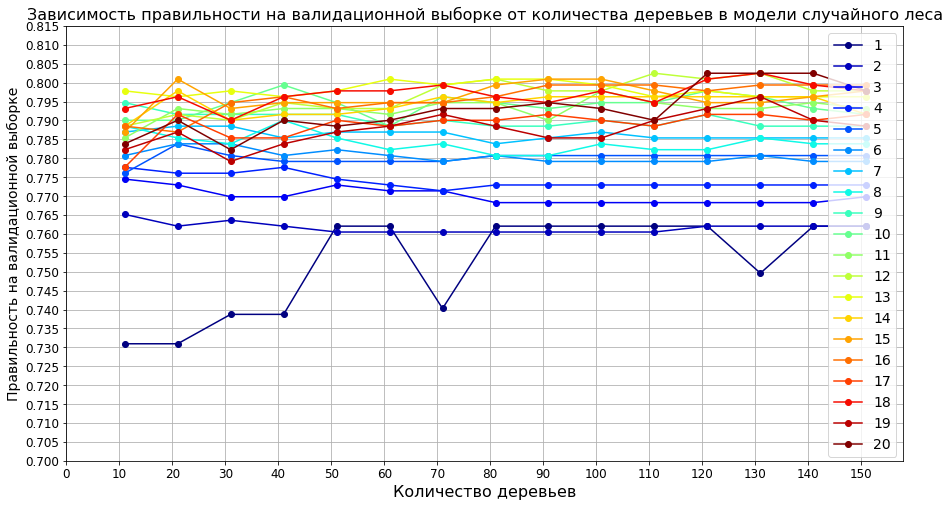

In [34]:
#размер графика
plt.figure(figsize=(15,8))

#выбор цветовой карты
colors = plt.cm.jet(np.linspace(0,1,max_forest_depth))

for depth,c in zip(range(1,(max_forest_depth+1)),colors):
    #строим график
    plt.plot(result_forest_depth[result_forest_depth['depth']==depth]['n_estimators'],
             result_forest_depth[result_forest_depth['depth']==depth]['forest_score'],
             '-o',
             label=depth,
             color=c
            )

#название графика
plt.title('Зависимость правильности на валидационной выборке от количества деревьев в модели случайного леса', fontsize=16)

#подписи осей
plt.xlabel('Количество деревьев', fontsize=16)
plt.ylabel('Правильность на валидационной выборке', fontsize=14)

#отображение сетки
plt.grid()

#задаём шаг сетки по оси по оси абсцисс и по оси ординат
plt.xticks(np.arange(0, 
                     (result_forest_depth['n_estimators'].max()*1.05), 
                     step=10),
           fontsize=12)
plt.yticks(np.arange(0.7, 
                     (result_forest_depth['forest_score'].max()*1.02), 
                     step=0.005), 
           fontsize=12)

plt.legend(fontsize=14)
plt.show()

Для иллюстрации намеренно выбрана цветовая карта `jet`: минимальной глубине 1 соответствует синий цвет (холодный), максимальная глубина 20, заданная в расчете, соответствует цвету, близкому к бордовому. Для каждой точки с количеством деревьев (от 1 до 160 с шагом 10) соответствует 20 точек с глубиной решающего дерева. 

График носит больше качественный характер, чем количественный. Он позволяет проследить, что для глубины решающего дерева в модели случайного леса в целом сохраняется тенденция, выявленная для модели решающего дерева: сначала **увеличение глубины** приводит к **росту правильности**, затем правильность **достигает некоторого пика**, после чего увеличение глубины приводит только **к ухудшению качества модели**. 

Однако при количестве деревьев от 110 и выше есть фрагмент графика, где увеличение глубины увеличивает качество, видно, что глубина 20 в этом диапазоне графика (110-150 деревьев) имеет максимальные значения. Но затем качество снова снижается.

Однако расчет показал, что наилучший результат правильности на валидационной выборке достигается при:
- количестве деревьев равном **111**,
- глубине решающего дерева равной **12**.

Правильность модели случайного леса с учетом глубины решающего дерева при этом составляет: **0.80248833592535**

Отметим также, что был выполен расчет с ещё более мелким шагом по количеству деревьев, равным `1` (160 вариантов по 20 итераций - в сумме 3200 итераций). Расчет **занял значительно больше времени**, точность возросла незначительно и сравнительный график был менее информативен. В связи с этим результат приводим в виде картинки без кода для информации:

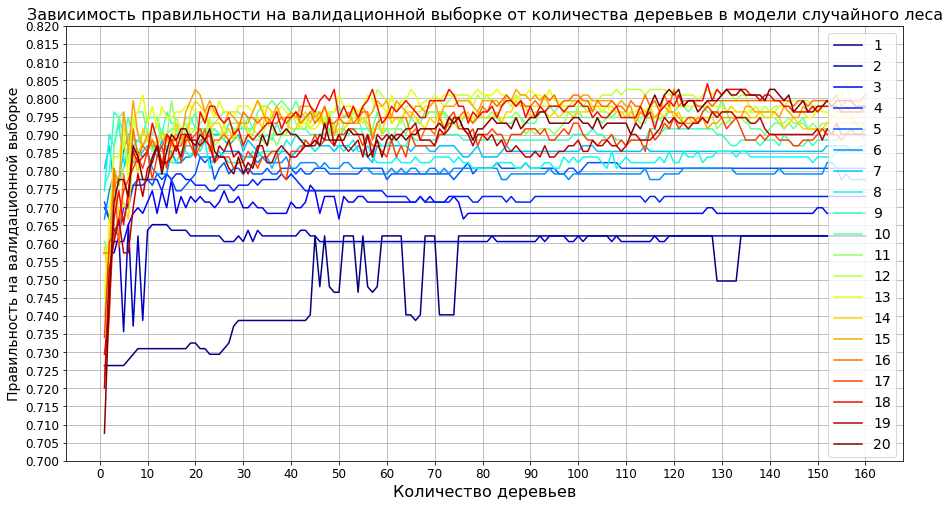

### Модель логистической регрессии

Также рассмотрим наиболее простую модель - **логистическую регрессию**. Зададим только 1 гиперпараметр - `random_state`:

In [35]:
# инициализируем модель логистической регрессии с параметром random_state=12345
model_log_regr = LogisticRegression(random_state=12345)

Обучим модель на тренировочной выборке:

In [36]:
# обучим модель на тренировочной выборке
model_log_regr.fit(features_train,target_train) 

LogisticRegression(random_state=12345)

Посчитаем правильность для валидационной выборки:

In [37]:
# получим метрику качества модели на валидационной выборке
result_log_regr = model_log_regr.score(features_valid,target_valid) 

print("Accuracy модели логистической регрессии на валидационной выборке:", result_log_regr)

Accuracy модели логистической регрессии на валидационной выборке: 0.7262830482115086


Получили в результате, что правильность модели логистической регрессии сопоставима с заполнением наиболее часто встречающимся значением. **Модель логистической регрессии не пройдёт проверку вменяемости.**

### Сравнение моделей

Мы рассмотрели 3 модели:
- дерево решений, 
- случайный лес (с учетом максимальной глубины дерева решений и без), 
- логистическую регрессию.

Соберём итоговую таблицу:

In [38]:
result_research_table = pd.DataFrame({'model_name':['DecisionTreeClassifier',
                                                    'RandomForestClassifier',
                                                    'RandomForestClassifier (with max_depth)',
                                                    'LogisticRegression'],
                                      
                                      'random_state':[12345,
                                                      12345,
                                                      12345,
                                                      12345],
                                      
                                      'max_depth':[best_depth_tree,
                                                   None,
                                                   best_result_depth_forest,
                                                   None],
                                      
                                      'n_estimators':[None,
                                                      best_result_est_2,
                                                      best_result_est_for_depth,
                                                      None],
                                      
                                      'accuracy_valid':[best_result_tree,
                                                        best_result_forest_2,
                                                        best_result_forest_depth, 
                                                        result_log_regr]})

Выведем правильность каждой из моделей и гиперпараметры:

In [39]:
result_research_table.sort_values(by='accuracy_valid',ascending=False).reset_index(drop=True)

,model_name,random_state,max_depth,n_estimators,accuracy_valid
0,RandomForestClassifier (with max_depth),12345,12.0,111.0,0.802488
1,RandomForestClassifier,12345,NaN,146.0,0.800933
2,DecisionTreeClassifier,12345,7.0,NaN,0.774495
3,LogisticRegression,12345,NaN,NaN,0.726283


Очевидно, что по значению `accuracy` для валидационной выборки **на 1 месте модель случайного леса с глубиной решающего дерева 12** и **количеством деревьев 111**.

Далее предстоит проверка моделей на тестовой выборке. Посмотрим, как изменится рейтинг качества по метрике `accuracy`.

### Вывод

Мы рассмотрели 3 модели:
- дерево решений, 
- случайный лес (с учетом максимальной глубины дерева решений и без), 
- логистическую регрессию.

Для всех моделей псевдослучайность задана равной `12345`.

По значению `accuracy` для валидационной выборки **на 1 месте модель случайного леса с глубиной решающего дерева 111** и **количеством деревьев 12**.

На втором месте модель случайного леса без учета глубины решающего дерева **со 146-ю деревьями**. 

На третьем - дерево решений с глубиной 7.

Модель логистической регрессии на валидационной выборке имеет правильность менее 0,7, соответственно, не проходит проверку адекватности.

## Проверка модели на тестовой выборке

Для проверки моделей на тестовой выборке создадим массив названий лучших моделей:

In [40]:
#массив названий переменных, в которых сохранены лучшие модели
array_models = ['best_model_tree',
               'best_model_forest_2',
                'best_model_forest_depth',
                'model_log_regr']

Запускаем цикл для расчета правильности каждой модели на тестовой выборке. Резльтат сохраняем в массив:

In [41]:
#массив правильности моделей на тестовой выборке
accuracy_test = []

#цикл по названиям переменных, в которых сохранены лучшие модели
for name in array_models:
    accuracy_test.append(locals()[name].score(features_test,target_test))

Добавим новый столбец `accuracy_test` в итоговую сравнительную таблицу:

In [42]:
#добавляем столбец accuracy_test
result_research_table['accuracy_test'] = accuracy_test

Выводим итоговую сравнительную таблицу.

In [43]:
#итоговая сравнительная таблица с сортировкой по убыванию столбца accuracy_test
result_research_table.sort_values(by='accuracy_test',ascending=False).reset_index(drop=True)

,model_name,random_state,max_depth,n_estimators,accuracy_valid,accuracy_test
0,RandomForestClassifier (with max_depth),12345,12.0,111.0,0.802488,0.797823
1,DecisionTreeClassifier,12345,7.0,NaN,0.774495,0.788491
2,RandomForestClassifier,12345,NaN,146.0,0.800933,0.788491
3,LogisticRegression,12345,NaN,NaN,0.726283,0.758942


Получили, что **на первом месте** по правильности модели на тестовой выборке - модель случайного леса с максимальной глубиной решающего дерева - 12, количеством деревьев - 111. Результат в сравнении с валидационной выборкой снизился незначительно. 

Стоит отметить, что качество улучшилось на тестовой выборке для модели решающего дерева. Причем **правильность одинакова** на тестовой выборке для моделей решающего дерева и случайного леса без учета глубины.

### Вывод

Выполнена проверка правильности (метрики `accuracy`) моделей на тестовой выборке:

- верхнюю строчку по правильности на тестовой выборке занимает **модель случайного леса** с количеством деревьев 111 и глубиной решающего дерева 12 - `accuracy_test` = **0.797823**,
- второе место разделили модели решающего дерева с глубиной 7 и модель случайного леса без учета глубины решающего дерева - `accuracy_test` = **0.788491**,
- качество логистической регрессии немного улучшилось, но всё равно мало для признания модели вменяемой.

## Проверка модели на адекватность

Проверку модели на вменяемость выполним с помощью `DummyClassifier` из модуля `sklearn.dummy`, который всегда предсказывает мажоритарный класс:

In [44]:
#задаём и обучаем модель на тренировочной выборке, предсказывающую мажоритарный класс 
dummy_majority = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)

Запишем предсказания данной модели:

In [45]:
#предсказания на тестовой выборке
pred_most_frequent = dummy_majority.predict(features_test)

И выведем уникальные предсказанные значения и правильность на тестовом наборе:

In [46]:
print("Уникальные спрогнозированные метки: {}".format(np.unique(pred_most_frequent)))
print("Правильность на тестовом наборе: {:.2f}".format(dummy_majority.score(features_test,target_test)))

Уникальные спрогнозированные метки: [0]
Правильность на тестовом наборе: 0.70


Получили результат, о котором уже говорили ранее: модель, которая предсказывает наиболее часто встречающийся класс, имеет правильность 70%. Соответсвенно, **70%** правильности - это минимальная планка для признания модели вменяемой. 

Как правило, **правильность не является адекватным показателем** прогностической способности бинарных моделей классификации, поскольку количество совершаемых ошибок не содержит весь объем интересующей нас информации.

Поэтому воспользуемся матрицей ошибок (`confusion_matrix`) из модуля `sklearn.metrics`.
И далее выведем результат для каждой из рассмотренных моделей.

In [47]:
print("Наиболее часто встречающийся класс:\n{}".format(confusion_matrix(target_test, 
                                                                        dummy_majority.predict(features_test))))

Наиболее часто встречающийся класс:
[[447   0]
 [196   0]]


In [48]:
print("Решающее дерево:\n{}".format(confusion_matrix(target_test, 
                                                     best_model_tree.predict(features_test))))

Решающее дерево:
[[421  26]
 [110  86]]


In [49]:
print("Случайный лес:\n{}".format(confusion_matrix(target_test, 
                                                   best_model_forest.predict(features_test))))

Случайный лес:
[[401  46]
 [ 90 106]]


In [50]:
print("Случайный лес с глубиной решений:\n{}".format(confusion_matrix(target_test, 
                                                                      best_model_forest_depth.predict(features_test))))

Случайный лес с глубиной решений:
[[408  39]
 [ 91 105]]


In [51]:
print("Логистическая регрессия:\n{}".format(confusion_matrix(target_test, 
                                                             model_log_regr.predict(features_test))))

Логистическая регрессия:
[[441   6]
 [149  47]]


Из матрицы ошибок видно, что наибольшее количество значений TP в моделях случайного леса, причем увеличение глубины решающего дерева позволяет увеличить TP на 1, а TN на 7. Но в целом эти две модели визуально близки по данным матрицы ошибок.

Матрица ошибок позволяет увидеть, что логистическая регрессия работает чуть лучше чем dummy классификатор.

Дополнительно можно посмотреть точность и полноту. 

Точность и полнота являются очень важными метриками, сами по себе они не дают полной картины. 

Одним из способов подытожить их является **F-мера (F-measure)**, которая представляет собой гармоническое среднее точности и полноты.

Поскольку f1-мера учитывает точность и полноту, то для бинарной классификации несбалансированных данных она может быть более лучшей метрикой, чем правильность.

Если мы хотим получить более развернутый отчет о точности, полноте и f1-мере, можно воспользоваться удобной функцией `classification_report`, чтобы вычислить все три метрики сразу.

Сделаем это с помощью цикла, поэтому обновим массив названий моделей, добавив в него dummy классификатор:

In [52]:
#добавляем dummy классификатор
array_models.insert(0,'dummy_majority')

#выводим массив моделей
array_models

['dummy_majority',
 'best_model_tree',
 'best_model_forest_2',
 'best_model_forest_depth',
 'model_log_regr']

Теперь с помощью цикла выведем результат для всех моделей (для dummy мы получим предупреждение, поскольку не было получено ни одного прогноза положительного класса, таким образом, знаменатель в формуле расчета f-меры равен нулю).

In [53]:
#запускаем цикл для вывода classification_report
for model in array_models:
    print('\033[1m'+model+'\033[0m')
    print(classification_report(target_test, locals()[model].predict(features_test),
                                target_names=["Smart", "Ultra"]))
    print()

dummy_majority
              precision    recall  f1-score   support

       Smart       0.70      1.00      0.82       447
       Ultra       0.00      0.00      0.00       196

    accuracy                           0.70       643
   macro avg       0.35      0.50      0.41       643
weighted avg       0.48      0.70      0.57       643


best_model_tree
              precision    recall  f1-score   support

       Smart       0.79      0.94      0.86       447
       Ultra       0.77      0.44      0.56       196

    accuracy                           0.79       643
   macro avg       0.78      0.69      0.71       643
weighted avg       0.79      0.79      0.77       643


best_model_forest_2
              precision    recall  f1-score   support

       Smart       0.82      0.90      0.86       447
       Ultra       0.70      0.54      0.61       196

    accuracy                           0.79       643
   macro avg       0.76      0.72      0.73       643
weighted avg       0.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Предсказать тариф Ультра правильно сложнее, чем Смарт, так как таких клиентов меньше, они встречаются реже.

Значит наилучшей можно считать ту модель, которая лучше предскажет миноритарный тариф - тариф Ультра. Но нужно искать компромисс между точностью и полнотой. В этом поможет f-мера.

### Вывод

Анализ **f-меры** показывает **преимущество модели случайного леса с учетом глубины решающего дерева** (`best_model_forest_depth`), f-мера для тарифа "Ультра" наивысшая и составляет `0.62`. 

Её результат немного лучше модели случайного леса без учета глубины решающего дерева (`best_model_forest_2`) f-мера для тарифа "Ультра" в этой модели составляет `0.61`.

Модель решающего дерева показывает f-меру равную `0.56` для тарифа "Ультра".

## Общий  вывод

1. В исходной таблице **3214** объектов. Каждый объект — информация о поведении одного пользователя за месяц. Доступна информация о 5 признаках: количество звонков, суммарная дилтельность звонков в минутах, количетсво sms, израсходованный интернет трафик в Мб, каким тарифом пользовался клиент в течение месяца. Целевой признак - столбец `is_ultra` (какой тариф).

2. Разбивка на обучающую, тестовую и валидационную выборки выполнена в соотношении **3:1:1**. Проверка контрольной суммы количества объектов показала, что разбивка выполнена корректно.

3. **`30.6%`** пользователей в исходной таблице имеют тариф **"Ультра"**. То есть в данном случае мы имеем дело с **несбалансированным целевым признаком**, который наиболее часто встречается в реальной жизни. Это необходимо учесть при проверке моделей на адекватность. Разбивка на тестовую, обучающую и валидационную выборки выполнена с сохранением несбалансированного целевого признака: клиентов с тарифом **Смарт около 70%**.

4. Исследование моделей машинного обучения показало:

- Правильность **модели решающего дерева** на валидационной выборке по мере увеличения глубины дерева растет до достижения значения глубины, равного 7. **При глубине 7** наблюдается максимум правильности. Затем с увеличением глубины начинается постепенное снижение правильности. Дальнейшее увеличение глубины приводит только к ухудшению правильности модели решающего дерева.

- **Модель случайного леса без учета глубины решающего дерева** позволила достигнуть правильности равной **0.800933** на валидационной выборке с количеством деревьев 146.

- Расчет показал, что наилучший результат правильности (0.802488) **модели случайного леса с учетом глубины решающего дерева** на валидационной выборке достигается при: количестве деревьев равном 111, глубине решающего дерева равной 12.

- Модель логистической регрессии имеет правильность на валидационной выборке около 70%, поэтому не является адекватной.

5. Проверка качества (в виде метрики `accuracy`) **на тестовой выборке** показала:
- верхнюю строчку по правильности на тестовой выборке занимает **модель случайного леса** с количеством деревьев 111 и глубиной решающего дерева 12 - `accuracy_test` = **0.797823**,
- второе место разделили модели решающего дерева с глубиной 7 и модель случайного леса без учета глубины решающего дерева - `accuracy_test` = **0.788491**,
- качество логистической регрессии немного улучшилось, но всё равно мало для признания модели вменяемой.

6. Проверка **модели на вменяемость** с помощью `dummy` классификатора, а также проверка **матрицы ошибок** и **f-меры** (на тестовой выборке), показали:
- **наибольшее количество значений TP** в моделях случайного леса, причем увеличение глубины решающего дерева позволяет увеличить TP на 1, а TN на 7. Но в целом эти две модели визуально близки по данным матрицы ошибок,
- Предсказать тариф Ультра правильно сложнее, чем Смарт, так как таких клиентов меньше, они встречаются реже. Значит наилучшей можно считать ту модель, которая лучше предскажет миноритарный тариф - тариф Ультра. Но нужно искать компромисс между точностью и полнотой. В этом поможет f-мера. 
- Анализ f-меры показывает **преимущество модели случайного леса с учетом глубины решающего дерева**, f-мера для тарифа "Ультра" в этой модели наивысшая и составляет 0.62. 
- Этот результат немного лучше модели случайного леса без учета глубины решающего дерева, f-мера для тарифа "Ультра" в которой составляет 0.61.
- Модель решающего дерева показывает f-меру равную 0.56 для тарифа "Ультра".

7. Как мы помним из курса "Статистический анализ данных", тариф Ультра дороже, он потенциально может принести большую прибыль. Поэтому **важно с помощью модели узнать клиентов, которым можем быть интересен тариф Ультра**. Модель может выигрывать, на первый взгяд, не так много в качестве. Но небольшое увеличение качества может увеличить конверсию клиентов, перешедших на данный тариф. Так как увеличение качества в первую очередь приводит к правильно индентифицированным клиентам тарифа "Ультра".